In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import scipy
from scikits import bootstrap as bootstrap
from collections import *
from scipy.interpolate import spline

In [64]:
venue_to_year = {}
with open('../data/anthology-online-dates.tsv') as f:
    for line_no, line in enumerate(f):
        if line_no == 0:
            continue
        cols = line[:-1].split('\t')
        year = int(cols[0])
        cols[2] = cols[2].replace(',', ';')
        venues = [x.strip() for x in cols[2].split(';') if len(x.strip()) > 0]        
        for v in venues:
            print v
            if 'thru' in v:
                start_end = v.split()
                start = start_end[0]
                end = start_end[2]
                if not '-' in start:
                    # print start, end
                    start_range = int(start[1:])
                    end_range = int(end[1:])
                    #print start, start_range, end, end_range
                    
                    prefix = start[0]
                    if end_range < start_range:
                        end_range += 100
                    for i in range(start_range, end_range+1):
                        venue = prefix + ('%02d' % (i % 100))
                        #print venue
                        venue_to_year[venue] = year                    
                else:
                    start_range = int(start.split('-')[1])
                    end_range = int(end.split('-')[1])

                    prefix = start.split('-')[0] + '-'
                    for i in range(start_range, end_range+1):
                        venue = prefix + ('%02d' % i)
                        #print venue
                        venue_to_year[venue] = year
            else:
                venue_to_year[v] = year

W12-62
O12
U12
Y12
J12-4
L12
W98-15
J12-3
P12
D12
W12-32 thru W12-45
W12-15
F12
W12-11 thru W12-14
W12-16
Y08-Y11
W12-17 thru W12-31
N12
S12
E12
W12-01 thru W12-10
J12-1
S01
U11
L06
L04
L02
L00
W00-15 thru W00-19
W11-29
W11-39 thru W11-43
W11-44
R11
L10
O11
J11-4
W11-29
W11-38
I11
W11-30 thru W11-37
J11-3
Jul: D11
W11-21 thru W11-27
P11
W11-02 thru W11-19
W11-20
J11-2
U03
U04
U10
W11-01
S98
J10-4
E03
J10-3
O10
W10-41
C10
W10-32 thru W10-40
P10
S10
W10-17 thru W10-30
R09
W09-40 thru W09-45
W10-31
J10-2
N10
W10-01 thru W10-16
U05 thru U09
O88 thru O09
J10-1
J09-4
W09-38
J09-3
W09-39
P09
D09
W09-25 thru W09-36
W09-37
J09-2
N09
W09-11 thru W09-24
J09-1
E09
W09-01 thru W09-10
W03-29
W05-11
J08
I05-1
J07
L08
W03-28
D08
C08
W08-12 thru W08-21
W08-22
W08-11
I08
P08
W08-01 thru W08-10
MT&CL
J06
W01-0500
W04-3200
W03-22 thru W03-27
M98
W03
W04
W07-23
J05
N07
W07
C04
N04
W04
P04
P06
N06
E06
J04
J03
J02
W02
U13
O13
R13
W13-51 thru W13-53
W13-38
J13-4
W13-41 thru W13-47
W13-49 thru W13-50
D13
I13
W

In [147]:
paper_to_citations = defaultdict(set)
cited_to_citing = defaultdict(set)
cited_to_typed_citing = defaultdict(set)

with open('../results/citation-graph/v5/cite-func.all.tsv') as f:    
    for line in f: 
        cols = line[:-1].split('\t')
        citing = cols[0][:8]
        cited = cols[1]
        function = cols[2]
        if 'xternal' in cited:
            continue
        paper_to_citations[citing].add((cited, function))
        cited_to_citing[cited].add(citing)
        cited_to_typed_citing[cited].add((citing, function))

In [148]:
all_papers = [x for x in set(paper_to_citations.iterkeys()) | set(cited_to_citing.iterkeys()) if not 'xtern' in x]

In [149]:
paper_to_year = {}
for p in all_papers:
    y = int(p[1:3])
    if y < 50:
        y += 2000
    else:
        y += 1900
    paper_to_year[p] = y

In [89]:
def get_cumulative_cites(pub_year, in_cites, min_years=10):
    years = []
    for p in in_cites:
        years.append(paper_to_year[p])
    year_counts = Counter(years)
    c_counts = []
    start_year = pub_year
    end_year = start_year + min_years
    if len(years) > 0:
        end_year = min(end_year, max(years)+1)
    end_year = min(2015, end_year)
    
    for i, y in enumerate(range(pub_year, end_year)):
        # not really possible, but avoid noise
        if y < pub_year:
            continue
        prev = 0
        if len(c_counts) > 0:
            try:
                prev = c_counts[-1]
            except:
                print pub_year, i, c_counts, year_counts
        c_counts.append(year_counts[y] + prev)
    return c_counts    

In [88]:
def get_cumulative_cite_types(pub_year, typed_in_cites, min_years=10):
    years = []
    essential_years = []
    positioning_years = []
    
    for (p, ctype) in typed_in_cites:
        year = paper_to_year[p]
        years.append(year)
        if ctype == 'Essential':
            essential_years.append(year)
        else:
            positioning_years.append(year)            

    ess_year_counts = Counter(essential_years)
    pos_year_counts = Counter(positioning_years)
    
    ess_c_counts = []
    pos_c_counts = []
    
    start_year = pub_year
    end_year = start_year + min_years    
    if len(years) > 0:
        end_year = min(end_year, max(years)+1)
    end_year = min(2015, end_year)
    
    for i, y in enumerate(range(start_year, end_year)):
        prev_e = 0
        prev_p = 0
        if len(ess_c_counts) > 0:
            prev_e = ess_c_counts[-1]
            prev_p = pos_c_counts[-1]
        
        ess_c_counts.append(ess_year_counts[y] + prev_e)
        pos_c_counts.append(pos_year_counts[y] + prev_p)

    return ess_c_counts, pos_c_counts

# Figure out which years we can use as matched samples

In [100]:
venue_to_delayed_years = defaultdict(set)

for ii, cited in enumerate(all_papers):

    pub_year = paper_to_year[cited]
    online_year = -1
    for i in range(len(cited), 2, -1):
        if cited[0:i] in venue_to_year:
            online_year = venue_to_year[cited[0:i]]
            break
    if online_year < 0:
        continue

    if pub_year != online_year:        
        venue = cited[0]
        venue_to_delayed_years[venue].add(pub_year)

In [155]:
timeline_df = []
pe_timeline_df = []

zero_cite_count = Counter()
workshop_count = Counter()

mismatch = 0
delayed = set()
tmp_delay_tracker = {}
#for ii, (cited, citing_papers) in enumerate(cited_to_citing.iteritems()):

for ii, cited in enumerate(all_papers):

    citing_papers = cited_to_citing[cited]
    typed_citing_papers = cited_to_typed_citing[cited]

    pub_year = paper_to_year[cited]
    online_year = -1
    prefix = ''
    for i in range(len(cited), 2, -1):
        if cited[0:i] in venue_to_year:
            online_year = venue_to_year[cited[0:i]]
            prefix = cited[0:i]
            #print '%s when online in %d' % (cited, online_year)
            break
    if online_year < 0:
        #print 'no year', cited
        continue

        
    # See whether we can use this venue's publication counts
    venue = cited[0]
    
    #if venue != 'C':
    #    continue

    
    delayed_years = venue_to_delayed_years[venue]
    is_valid = False
    for dy in delayed_years:
        if pub_year >= dy-2 and pub_year <= dy+2:
            is_valid = True
            break

    #print cited, is_valid
            
    #if not is_valid:
    #    continue
        
    cumulative_counts = get_cumulative_cites(pub_year, citing_papers)
    #print cumulative_counts
    cumulative_essential_counts, cumulative_positioning_counts = \
        get_cumulative_cite_types(pub_year, typed_citing_papers)

    if venue == 'W':
        workshop_count[prefix] += 1
        if sum(cumulative_counts) == 0:
            zero_cite_count[prefix] += 1
        
    delay_cohort = 0
    if pub_year != online_year:
        #print '%s was published in %d but when online in %d' % (cited, pub_year, online_year)
        mismatch += 1 
        # print cited, pub_year, (online_year - pub_year)
        delay_cohort = online_year - pub_year
        delayed.add(prefix)
        tmp_delay_tracker[prefix] = online_year - pub_year

    for i, num_cites in enumerate(cumulative_counts):
        timeline_df.append({
                'paper': cited,
                'years_since_pub': i,
                'venue': cited[0],
                'total_cites': num_cites,
                'total_essential_cites': cumulative_essential_counts[i],
                'total_positioning_cites': cumulative_positioning_counts[i],
                'online_delay': delay_cohort,
                'pub_year': pub_year
            })
        pe_timeline_df.append({
                'paper': cited,
                'years_since_pub': i,
                'venue': cited[0],
                'total_cites': cumulative_essential_counts[i],
                'cite_type': 'Essential',
                'online_delay': delay_cohort,
                'pub_year': pub_year                
            })   
        pe_timeline_df.append({
                'paper': cited,
                'years_since_pub': i,
                'venue': cited[0],
                'total_cites': cumulative_positioning_counts[i],
                'cite_type': 'Positioning',
                'online_delay': delay_cohort,
                'pub_year': pub_year                
            })         
    # TODO: Compare simple in-citation frequency by year, stratifying by # of years before going online
        
    # TODO: Created matched cohorts of papers that are cited with roughly equal frequency
    # TODO: Calculate the citation function distribution in the +/-2 years before and after the paper goes online
    # TODO: Compare the before/after citation distribution with papers that went online from the start
    #if ii > 10:
    #    break
        
print mismatch
timeline_df = pd.DataFrame(timeline_df)
pe_timeline_df = pd.DataFrame(pe_timeline_df)

subset = timeline_df[timeline_df['online_delay'] <= 5]
subset = subset[subset['years_since_pub'] <= 10]

pe_subset = pe_timeline_df[pe_timeline_df['online_delay'] <= 5]
pe_subset = pe_subset[pe_subset['years_since_pub'] <= 10]

for workshop, num_papers in workshop_count.iteritems():
    if workshop in delayed:
        print workshop, tmp_delay_tracker[workshop], zero_cite_count[workshop] / float(num_papers)

1878
W05-11 4 0.428571428571
W02-21 11 1.0
W04 3 0.414285714286
W02 2 0.330578512397
W03 5 0.339768339768
W00-15 11 1.0
W00-16 11 1.0
W00-19 11 1.0
W07-23 1 1.0
W03-29 6 1.0
W03-28 5 0.666666666667
W03-25 5 1.0
W03-24 5 1.0
W03-27 5 1.0
W03-26 5 1.0
W03-23 5 1.0
W03-22 5 1.0
W12-56 1 1.0
W12-52 1 1.0
W12-53 1 1.0
W12-50 1 1.0
W12-51 1 1.0
W12-58 1 1.0
W12-59 1 1.0
W12-55 1 1.0
W12-47 1 1.0
W12-49 1 1.0
W12-48 1 1.0
W12-60 1 1.0
W98-15 14 1.0
W09-42 1 1.0
W11-45 2 1.0
W12-57 1 1.0
W12-63 1 1.0
W12-61 1 1.0
W09-45 1 1.0
W09-44 1 1.0
W09-41 1 1.0
W09-40 1 1.0
W09-43 1 1.0
W00-18 11 1.0
W00-17 11 1.0


In [131]:
set(timeline_df['online_delay'])

{0, 2}

In [132]:
# subset[subset['venue'] == 'N'].head(100)

In [142]:
w_pe_subset = pe_subset[pe_subset['venue'] == 'W']
# w_pe_subset.head(100)

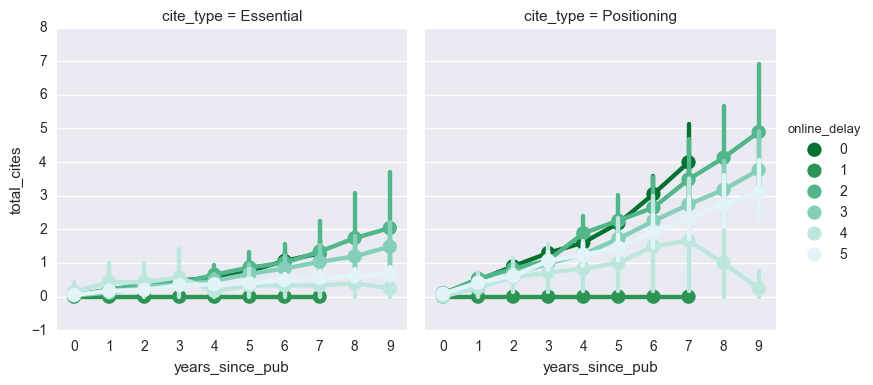

In [143]:
g = sns.factorplot(x="years_since_pub", y="total_cites", col="cite_type", 
                   hue='online_delay', col_wrap=2, sharey=True, data=w_pe_subset,
                   palette='BuGn_r')

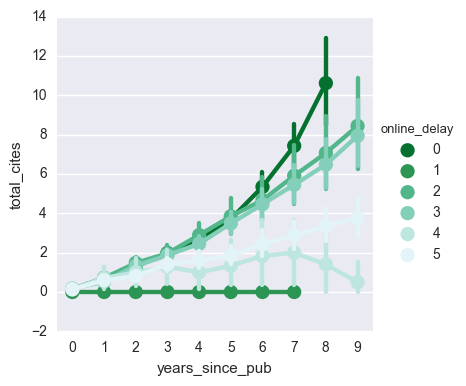

In [137]:
g = sns.factorplot(x="years_since_pub", y="total_cites", hue="online_delay", 
                   sharey=False, data=subset[subset['venue'] != 'J'],
                   palette='BuGn_r')

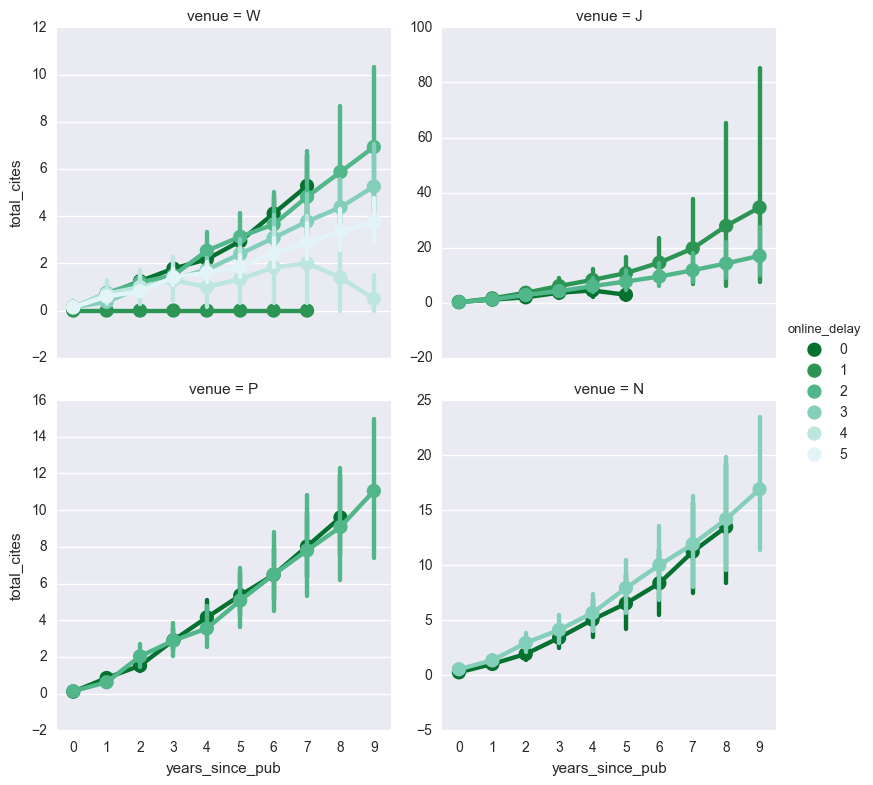

In [145]:
to_use = set(['W', 'J', 'P', 'N'])
g = sns.factorplot(x="years_since_pub", y="total_cites", hue="online_delay", 
                   col='venue', col_wrap=2, sharey=False, data=subset[subset['venue'].isin(to_use)],
                   palette='BuGn_r')

C 1
I 1
J 3
N 1
P 1
W 6


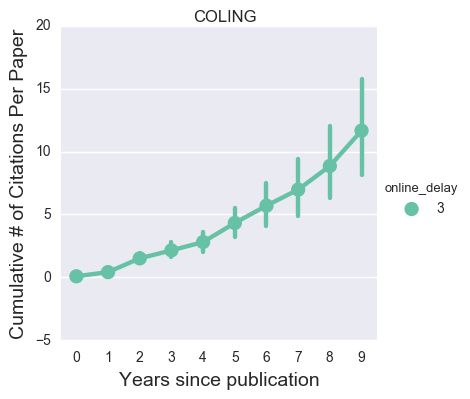

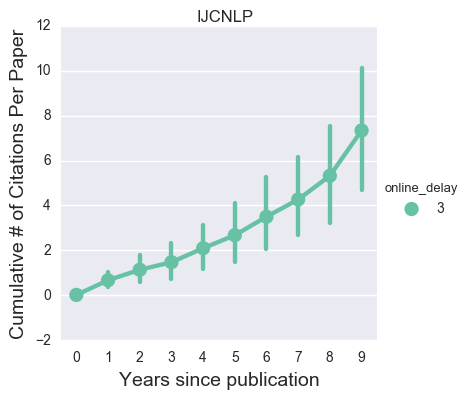

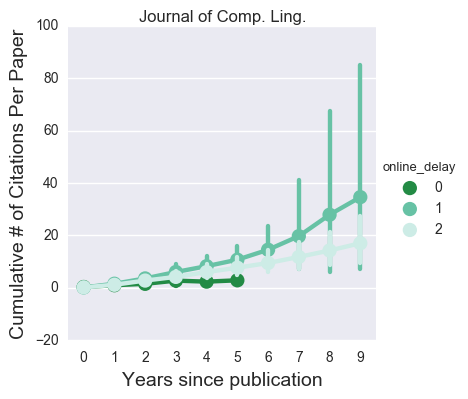

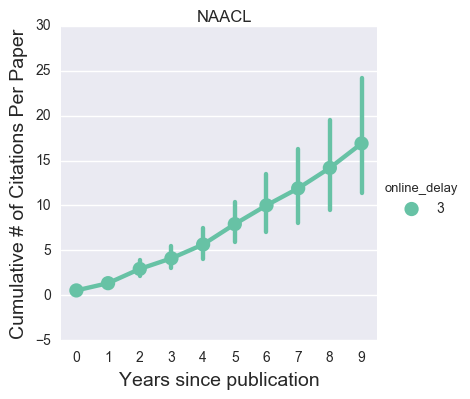

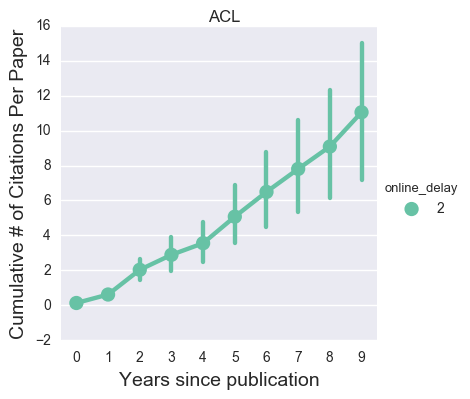

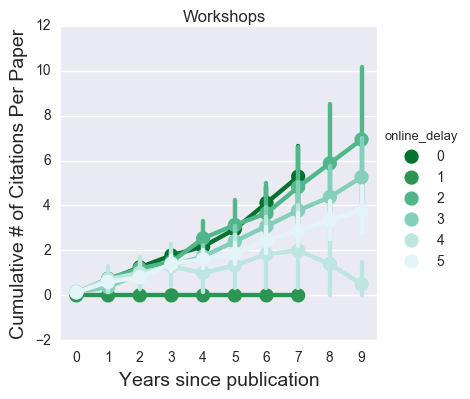

In [119]:
venues = set(subset['venue'])
venue_names = {
    'P': 'ACL', 'N': 'NAACL', 'C': "COLING", 'I': 'IJCNLP', 'W': 'Workshops', 'J': 'Journal of Comp. Ling.', 
}

for venue in venues:
    venue_df = subset[subset['venue'] == venue]
    delays = set(venue_df['online_delay'])
    print venue, len(delays)
    #if len(delays) == 1:
    #    continue
    
    g = sns.factorplot(x="years_since_pub", y="total_cites", hue="online_delay", 
                       data=venue_df, palette='BuGn_r')
    g.fig.suptitle(venue_names[venue])
    ax = plt.gca()
    ax.set_ylabel('Cumulative # of Citations Per Paper', fontsize=14)
    ax.set_xlabel('Years since publication', fontsize=14)      

In [96]:
w_subset = subset[subset['venue'] == 'W']
c_subset = subset[subset['venue'] == 'C']
p_subset = subset[subset['venue'] == 'P']

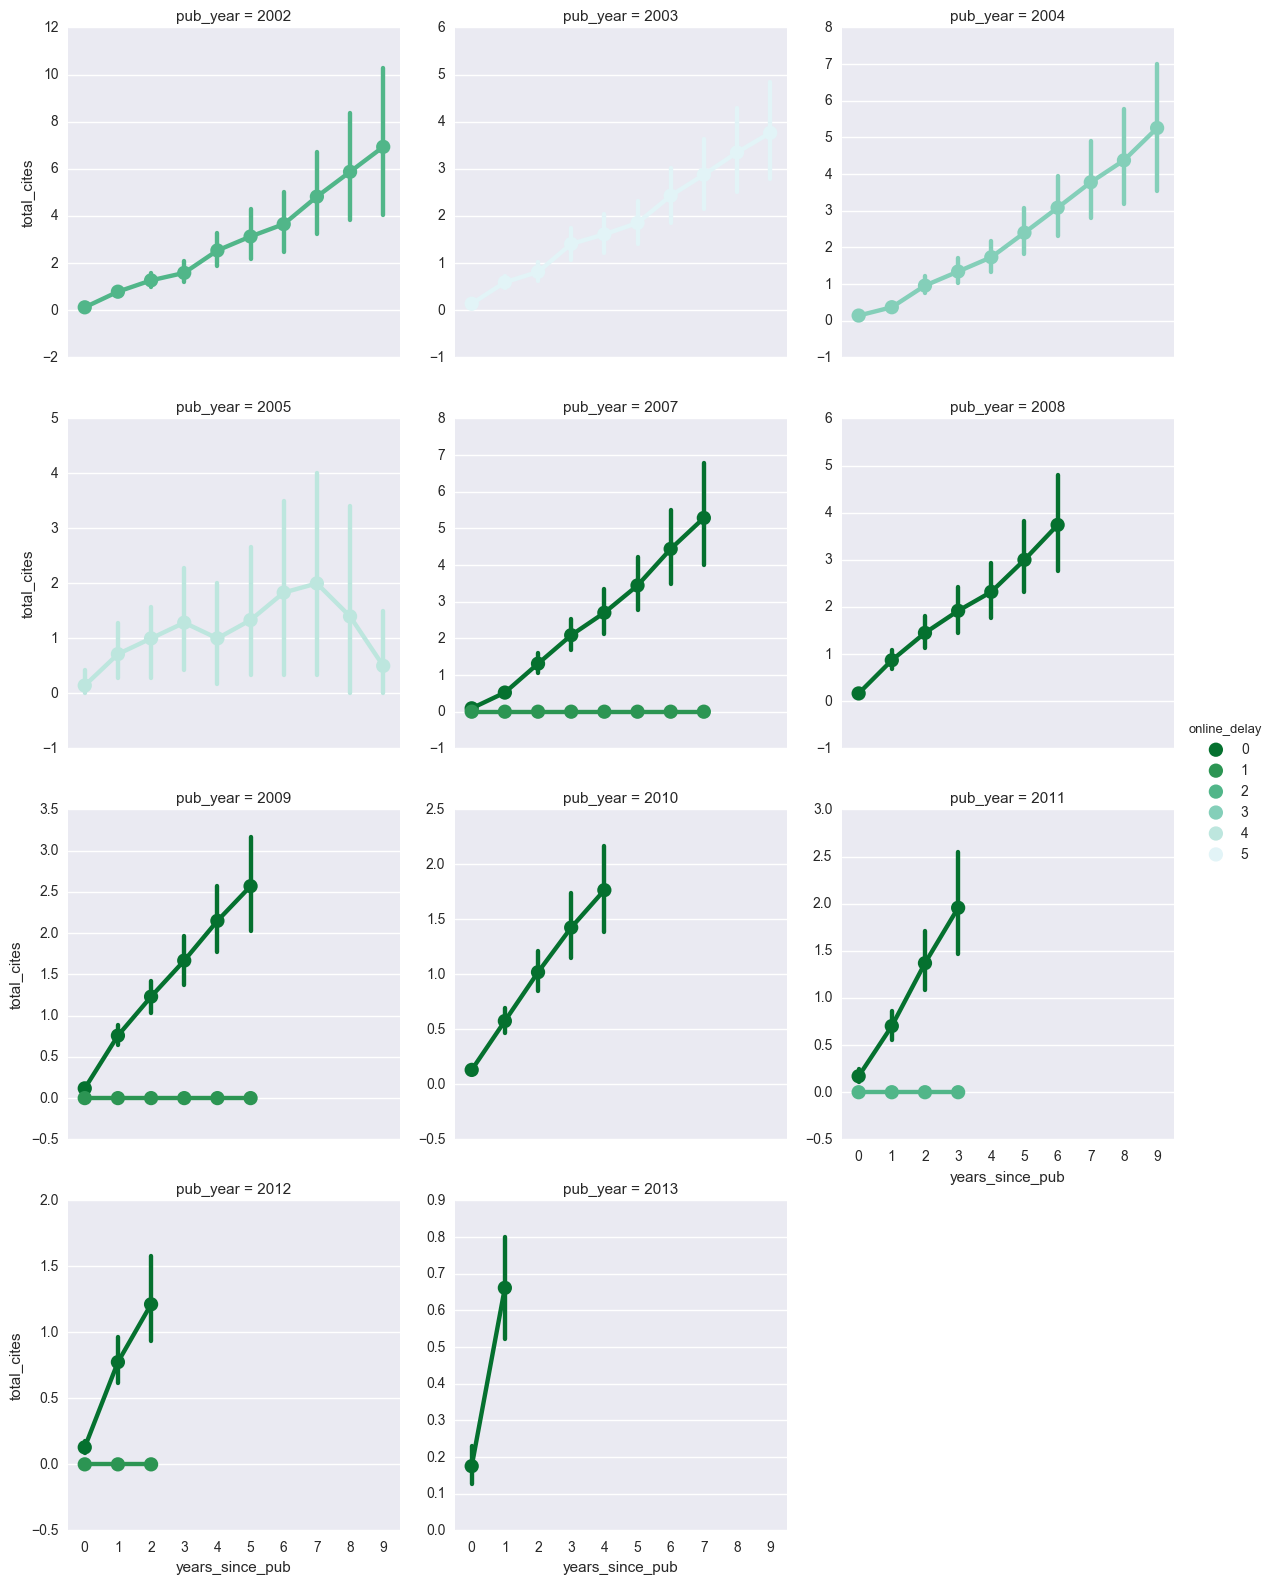

In [97]:
g = sns.factorplot(x="years_since_pub", y="total_cites", hue="online_delay", 
                   col='pub_year', col_wrap=3, sharey=False, data=w_subset,
                   palette='BuGn_r')